<a href="https://colab.research.google.com/github/iey704/ComputerVision/blob/main/CV_AL2_EfficientNetv2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   AdamP optimizer 사용
*   Label Smoothing = 0.11
*  efficientnet-b0 모델 사용
* Data Augmentation:Geomentric transform + Visual corruptions





In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


In [3]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=f9a4b8c1ba1a8662b257df9b7986fad70d09af5732d190e9ea9b6c1f7a58087f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [4]:
!pip3 install adamp

  Preparing metadata (setup.py) ... done
  Created wheel for adamp: filename=adamp-0.3.0-py3-none-any.whl size=5982 sha256=5057ea655ae1e9fcd6c1a49168afc25d9050c90f09ccc6d143d387e292a30851
  Stored in directory: /root/.cache/pip/wheels/c7/ad/0f/b41b1c45b18c66e5eef5d2254415af8055c7e2b0934145157d
Successfully built adamp


In [5]:
import os
import time

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image,ImageEnhance

from efficientnet_pytorch import EfficientNet

from torch.utils.data import ConcatDataset
from collections import Counter

from adamp import AdamP

import wandb    # Import Weight&Biases

# 랜덤 시드 설정 공통
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [6]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
# initialize Weight&Biases settings
run = wandb.init(
    project="Active_learning_2",
    notes = "CV_AL_2_final.ver",
    name = "efficientnet-b0")

cfg = {
    "architecture": "CNN",
    "dataset": "CUB2011",
    "classes": 50,
    "learning_rate": 0.0001,
    "epochs": 30,
    "batch_size": 8,
    "seed": 42,
    "label_smoothing": 0.11
}
wandb.config.update(cfg)


# Define Hyperparameters
lr = cfg['learning_rate']
BATCH_SIZE = cfg['batch_size']
EPOCH = cfg['epochs']
print("\n<Hyperparameters>\nEPOCH = {}\nBATCH SIZE = {}\nLearning rate = {}\t" .format(EPOCH, BATCH_SIZE, lr))

wandb: Currently logged in as: iey704. Use `wandb login --relogin` to force relogin



<Hyperparameters>
EPOCH = 30
BATCH SIZE = 8
Learning rate = 0.0001	


In [8]:
### Custom Dataset ###
class CUB2011(Dataset):
  def __init__(self, transform, mode='train'):
    self.transform = transform
    self.mode = mode

    if self.mode == 'train':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/train')
    elif self.mode == 'valid':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/valid')
    elif self.mode == 'test':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/test')

  def __len__(self):
    return len(self.image_folder)

  def __getitem__(self, idx):
    img_path = self.image_folder[idx]
    img = Image.open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets', self.mode, img_path)).convert('RGB')
    img = self.transform(img)
    label = img_path.split('_')[-1].split('.')[0]
    label = int(label)
    return (img, label)

In [9]:
# Geomentric transform + Visual corruptions
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            img_array = np.array(img)
            noise = np.random.normal(self.mean, self.std, img_array.shape)
            noisy_image = np.clip(img_array + noise, 0, 255)  # Clip values to the range [0, 255]
            return Image.fromarray(noisy_image.astype(np.uint8))
        else:
            return img

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std}, p={self.p})'


class AdjustContrast(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'

class AdjustBrightness(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'

In [10]:
### Data Preprocessing & Data Augmentation ###
transforms_train_origin = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),])

transforms_test = transforms.Compose([
    transforms.Resize((448,448)),
    transforms.ToTensor(),])

# Geomentric transform + Visual corruptions
transforms_train_g_v = transforms.Compose([
    transforms.Resize((448, 448)),
    #transforms.RandomResizedCrop(448),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(30),
    AddGaussianNoise(mean=0, std=25, p=0.5),  # 가우시안 노이즈를 추가합니다.
    AdjustContrast(factor=2.0),  # 대비를 조절합니다.
    AdjustBrightness(factor=1.5),  # 밝기를 조절합니다.
    transforms.ToTensor(),
])

BATCH_SIZE = 8

train_set_origin = CUB2011(mode='train',
                    transform=transforms_train_origin)
val_set = CUB2011(mode='valid',
                  transform=transforms_test)
test_set = CUB2011(mode='test',
                  transform=transforms_test)

train_set_augmented2 = CUB2011(mode='train',transform=transforms_train_g_v) # 2)

train_loader = DataLoader(train_set_origin,batch_size=BATCH_SIZE,shuffle=True)

# 다 합친거
train_set_combined = ConcatDataset([train_set_origin,train_set_augmented2])

print('Num of each dataset: ',len(train_set_combined),len(val_set),len(test_set))

# Dataloader class는 bath기반의 딥러닝모델 학습을 위해서 mini batch를 만들어주는 역할을 한다
# dataloader를 통해 dataset의 전체 데이터가 batch size로 나뉘게 된다
train_loader = DataLoader(train_set_combined, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)

print("Loaded dataloader")

Num of each dataset:  4720 296 298
Loaded dataloader


Batch 1


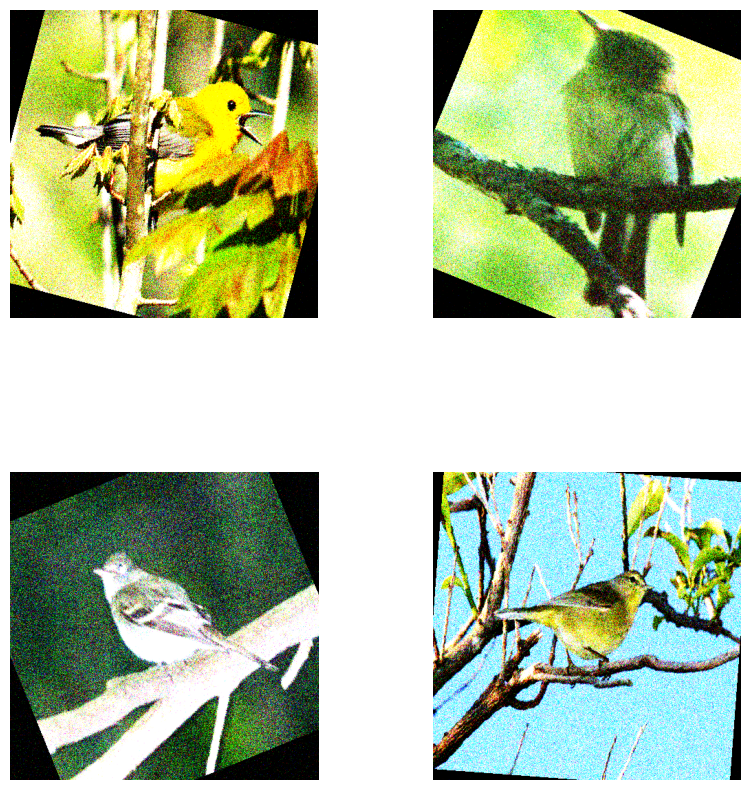

Batch 2


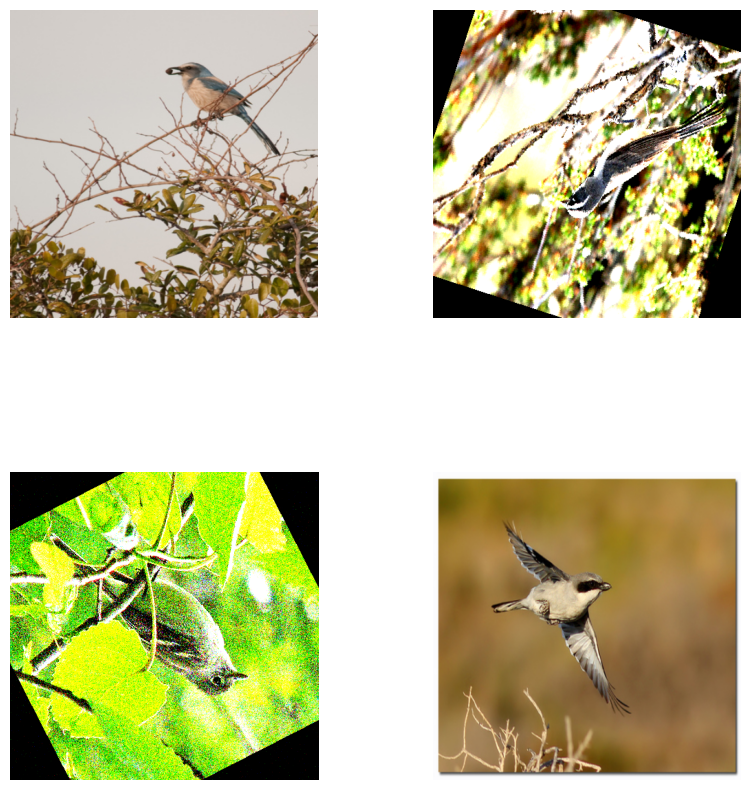

In [11]:
import matplotlib.pyplot as plt

num_rows = 2  # You can change this to the desired number of rows
num_cols = 2  # You can change this to the desired number of columns

# Function to unnormalize and display a grid of images
def imshow_grid(images, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < len(images):
                img = images[index]
                npimg = img.numpy()
                ax = axes[i, j]
                ax.imshow(np.transpose(npimg, (1, 2, 0)))
                ax.axis('off')

    plt.show()

# Iterate through the train_loader
for batch_idx, (images, labels) in enumerate(train_loader):
    if batch_idx >= 2:
        break  # Stop after visualizing the specified number of batches

    print(f"Batch {batch_idx + 1}")
    imshow_grid(images, num_rows, num_cols)  # Display the grid of images

In [12]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.6 MB/s eta 0:00:00


In [13]:
from transformers import get_cosine_schedule_with_warmup

### Model / Optimizer ###
EPOCH = 30
lr = 0.0001

#model = torch.hub.load('hankyul2/EfficientNetV2-pytorch', 'efficientnet_v2_s', pretrained=True, nclass=50)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=50)
print(model)

### Tranfer Learning ###
model.to(DEVICE)

optimizer = AdamP(model.parameters(), lr=lr)

scheduler = get_cosine_schedule_with_warmup(optimizer,
                                    num_warmup_steps=len(train_loader)*3,
                                    num_training_steps=len(train_loader)*EPOCH)

print("Created a learning model and optimizer")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:17<00:00, 1.21MB/s]


Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

In [14]:
### Train/Evaluation ###
def train(model,train_loader,optimizer,epoch, scheduler):
  model.train()
  criterion = nn.CrossEntropyLoss(label_smoothing=0.11)
  for i,(image,target) in enumerate(train_loader):
    image,target = image.to(DEVICE),target.to(DEVICE)
    output = model(image)
    optimizer.zero_grad()
    train_loss = criterion(output,target)

    train_loss.backward()
    optimizer.step()

    if scheduler != None:
      scheduler.step()

    if i%10 ==0:
      print(
          f'Train Epoch: {epoch} [{i}/{len(train_loader)}]\tloss: {train_loss.item():6f}')

  return train_loss

def evaluate(model,val_loader):
  model.eval()
  eval_loss = 0
  correct = 0
  with torch.no_grad():
    for i,(image,target) in enumerate(val_loader):
      image,target = image.to(DEVICE),target.to(DEVICE)
      output = model(image)

      eval_loss += F.cross_entropy(output,target, reduction='sum').item()
      pred = output.max(1,keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

  eval_loss /= len(val_loader.dataset)
  eval_accuracy = 100*correct / len(val_loader.dataset)
  return eval_loss,eval_accuracy

In [15]:
wandb.define_metric("train_loss", summary = "min")
wandb.define_metric("val_loss", summary = "min")
wandb.define_metric("val_acc", summary = "max")

In [16]:
### Main ###
start = time.time()
best = 0
train_losses = []  # 훈련 손실을 저장할 목록
val_losses = []    # 검증 손실을 저장할 목록
val_accuracys = []

for epoch in range(EPOCH):
  train_loss = train(model,train_loader,optimizer,epoch, scheduler)
  val_loss,val_accuracy = evaluate(model,val_loader)
  # Log train loss, validation loss, and validation accuracy into Weight & Biases by the function of epoch
  wandb.log({"train_loss": train_loss, "val_loss": val_loss, "val_acc": val_accuracy}, step=epoch)

# 훈련 및 검증 손실을 목록에 추가
  train_losses.append(train_loss)
  val_losses.append(val_loss)

  # Save best model
  if val_accuracy > best:
    best = val_accuracy
    torch.save(model.state_dict(),"./best_model.pth")

  val_accuracys.append(val_accuracy)
  print(f"[{epoch}]Validation Loss: {val_loss:.4f},Accuracy: {val_accuracy:.4f}%")

# Test result
test_loss,test_accuracy = evaluate(model,test_loader)
print(f'[FINAL] Test Loss: {test_loss:.4f},Accuracy: {test_accuracy:.4f}%')

end = time.time()
elasped_time = end - start

print("Best Accuracy: ",best)
print(
    f"Elasped Time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")
print(
    f"time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")

Train Epoch: 0 [0/590]	loss: 3.925517
Train Epoch: 0 [10/590]	loss: 3.922631
Train Epoch: 0 [20/590]	loss: 4.001979
Train Epoch: 0 [30/590]	loss: 3.896855
Train Epoch: 0 [40/590]	loss: 3.971822
Train Epoch: 0 [50/590]	loss: 3.859735
Train Epoch: 0 [60/590]	loss: 3.937198
Train Epoch: 0 [70/590]	loss: 3.926484
Train Epoch: 0 [80/590]	loss: 3.846335
Train Epoch: 0 [90/590]	loss: 3.811755
Train Epoch: 0 [100/590]	loss: 3.891694
Train Epoch: 0 [110/590]	loss: 3.910736
Train Epoch: 0 [120/590]	loss: 3.913420
Train Epoch: 0 [130/590]	loss: 3.913028
Train Epoch: 0 [140/590]	loss: 3.963677
Train Epoch: 0 [150/590]	loss: 3.962333
Train Epoch: 0 [160/590]	loss: 3.915305
Train Epoch: 0 [170/590]	loss: 3.911875
Train Epoch: 0 [180/590]	loss: 3.938751
Train Epoch: 0 [190/590]	loss: 3.950321
Train Epoch: 0 [200/590]	loss: 3.917567
Train Epoch: 0 [210/590]	loss: 3.865175
Train Epoch: 0 [220/590]	loss: 3.854756
Train Epoch: 0 [230/590]	loss: 3.982206
Train Epoch: 0 [240/590]	loss: 3.968447
Train Epoch

In [27]:
# Finish Weight & Biases
wandb.finish()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7aca83301780>> (for pre_run_cell):


BrokenPipeError: ignored

BrokenPipeError: ignored

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7aca83301780>> (for post_run_cell):


BrokenPipeError: ignored

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7aca83301780>> (for pre_run_cell):


BrokenPipeError: ignored

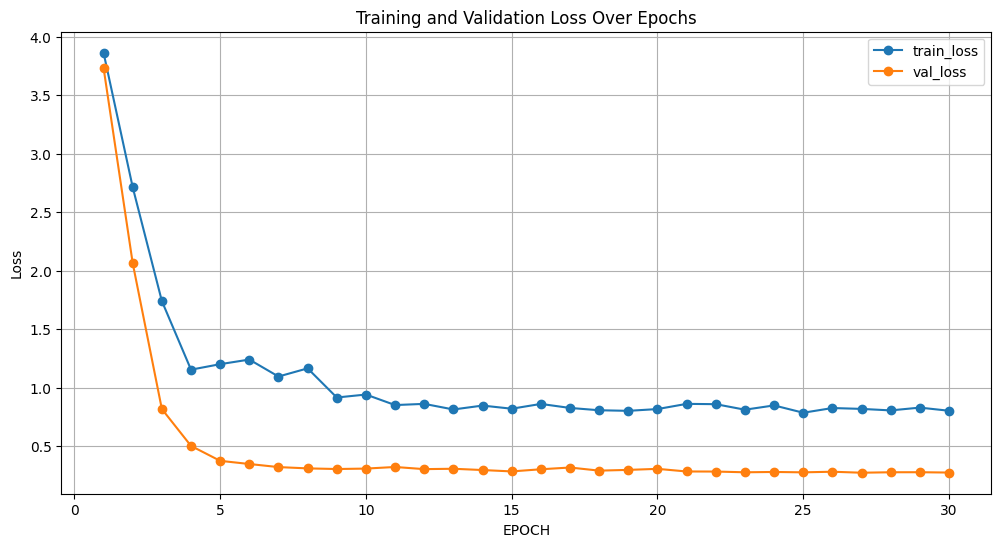

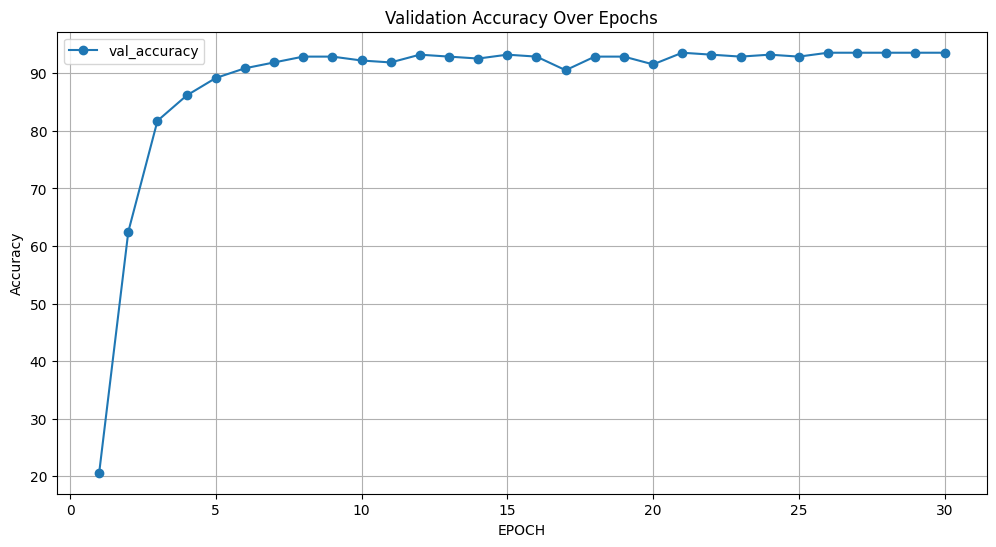

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7aca83301780>> (for post_run_cell):


BrokenPipeError: ignored

In [26]:
# 이제 손실 값을 플로팅합니다.
import matplotlib.pyplot as plt

# train_loss와 val_loss 텐서를 CPU로 이동하고 NumPy 배열로 변환
train_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), train_losses, label='train_loss', marker='o')
plt.plot(range(1, EPOCH + 1), val_losses, label='val_loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


val_accuracys = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_accuracys]
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), val_accuracys, label='val_accuracy', marker='o')
plt.title('Validation Accuracy Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()